In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn import utils
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 35}

matplotlib.rc('font', **font)



RDKit WARNING: [03:07:46] Enabling RDKit 2019.09.1 jupyter extensions


In [6]:
#read the file containing the ecfp and isomer(1 or 2)
input_996=pd.read_csv('input_996.csv') #load sigma & isomer
efp_996=pd.read_csv('ecfp_256.csv') #load ecfp
efp_996=np.array(efp_996) #array form

Isomer=input_996[['Isomer']].copy() #copy isomer
X_996=np.concatenate((efp_996,Isomer),axis=1) #make compete fp
X_996.shape

(996, 258)

In [5]:
#assign the Hammett constants to Y
Y_996=input_996[['Hammett Constant']].copy() #copy sigma values
Y_996=np.array(Y_996) #array form
Y_996.shape

(996, 1)

In [8]:
efp_ndonor=pd.read_csv('ecfp_ndonor.csv') #load sigma & isomer of ndonors
efp_ndonor=np.array(efp_ndonor) #array form
X_ndonor=efp_ndonor #assign to X_ndonor
X_ndonor.shape

(10, 258)

depth: 15
0
1
2
3
4
5
6
7
8
9
10


/Users/blair/anaconda3/envs/py36_standby/lib/python3.6/site-packages/ipykernel_launcher.py:324: RuntimeWarning: invalid value encountered in double_scalars
/Users/blair/anaconda3/envs/py36_standby/lib/python3.6/site-packages/ipykernel_launcher.py:385: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Users/blair/anaconda3/envs/py36_standby/lib/python3.6/site-packages/ipykernel_launcher.py:392: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Users/blair/anaconda3/envs/py36_standby/lib/python3.6/site-packages/ipykernel_launcher.py:399: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


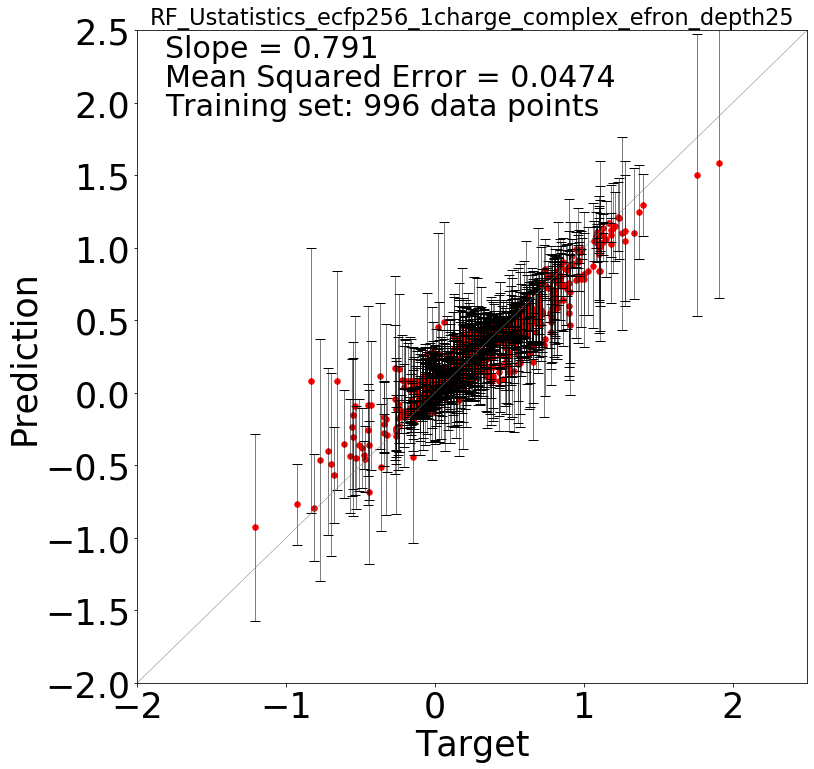

In [22]:
for depth in range(15, 16):
    print('depth:', depth)
    mol_num = 996 #number of molecule 
    tree_num = 11 #number of trees

    #create null list to record bootsraping index
    index_boot=np.zeros((tree_num,mol_num),dtype=int)
    
    #null list to record all mse of training set wrt all bootstrapping
    MSE_train_all = [] 
    
    #to record all mse of testing set wrt all bootstrapping
    MSE_test_all = [] 
    
    #to record alpha values
    alpha_all = []
    
    #to record the index of row which contains negative alpha
    ind_minus_alpha_row = [] 
    
    #to record the index of column which contains negative alpha
    ind_minus_alpha_column = []
    
    #to record negative alpha
    minus_alpha = []

    for m in range(0,tree_num):
        
        #all parameters are default
        regr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=depth,
                                     min_samples_split=2, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_features=None, random_state=None,
                                     max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     min_impurity_split=None, presort='deprecated', ccp_alpha=0.0)
        
        #create bootstraping indices（len = 996）
        index_996 = np.random.choice(mol_num, size = mol_num, replace = 1)
        
        #save mth bs indices in mth vacancy of vacancy
        index_boot[m] = index_996
        
        #select training X data from X_996
        X_train=X_996[index_996]
        
        #select training Y data from Y-996
        Y_train=Y_996[index_996]
        
        #select the remaining X as testing data
        X_test=np.delete(X_996,index_996,axis=0)
        
        #select the remaining Y as testing data
        Y_test=np.delete(Y_996,index_996,axis=0)
        
        #assign to new variables 
        X_resample= X_train
        Y_resample= Y_train
        
        #call function to find alpha values 
        model = regr.cost_complexity_pruning_path(X_resample, Y_resample.ravel())
        
        #find alpha and impurities
        ccp_alphas, impurities = model.ccp_alphas, model.impurities
        
        
        for i in range(0,len(ccp_alphas)):
            if ccp_alphas[i] < 0:
                #in very unusual cases, the alpha values are negative, find it and make it zero
                ind_minus_alpha_row.append(m)
                ind_minus_alpha_column.append(i)
                minus_alpha.append(ccp_alphas[i])
                ccp_alphas[i] = 0
        
        #save alpha, shape = (tree_num, len(seies))
        alpha_all.append(ccp_alphas)
        
        #fit training data with all alphas and save the models
        regrs = []
        for ccp_alpha in ccp_alphas:
            regr = DecisionTreeRegressor(ccp_alpha = ccp_alpha, max_depth=depth)
            regr.fit(X_resample, Y_resample.ravel())
            regrs.append(regr)
        
        #to record all mse with respect to one bootstrapping
        MSE_train = []
        MSE_test = []
        
        
        for regr in regrs:
            #use each model to make training predictions
            Y_pred_train = regr.predict(X_train)
            
            #use each model to make testing predictions
            Y_pred_test = regr.predict(X_test)
            
            #training mse
            MSE_train_each = mean_squared_error(Y_resample, Y_pred_train)
            
            #testing mse
            MSE_test_each = mean_squared_error(Y_test, Y_pred_test)
            
            #record all mse
            MSE_train.append(MSE_train_each)
            MSE_test.append(MSE_test_each)
        
        #make it a array
        MSE_train = np.array(MSE_train)  
        MSE_test = np.array(MSE_test) 

        #record all mse in MSE_train_all and MSE_test_all
        MSE_train_all.append(MSE_train)
        MSE_test_all.append(MSE_test)

        print(m)
        
    #find the length of shortest seies
    min_length = np.amin([len(MSE_train_all[a]) for a in range(len(MSE_train_all))])

    #null list to record all mse in the length of the shortest series 
    train_error = np.zeros((tree_num, min_length), dtype = float)
    test_error = np.zeros((tree_num, min_length), dtype = float)

    #save mse in the null list, len(MSE_test_all) = tree_num = 1000
    for row_num in range(0, len(MSE_test_all)):
        train_error[row_num] = MSE_train_all[row_num][:min_length].ravel()
        test_error[row_num] = MSE_test_all[row_num][:min_length].ravel()
        
    #efron error, shape = (tree_num, len(shortest series))
    sum_error = np.add(train_error * 0.368, test_error * 0.632)
  
    #null list to record the index of the best tree in all series
    ind_min_mse_each = []
    
    #find the the indices and save them, len(MSE_test_all) = tree_num = 1000
    for row_num in range (0, len(MSE_test_all)):
        ind_min_mse_each.append(np.argmin(sum_error[row_num]))

    #null list to record best alphas
    alpha_min_cost = []
    
    #find best alphas and save them, length = 1000
    for n in range(0,len(alpha_all)):
        alpha_min_cost.append(alpha_all[n][ind_min_mse_each[n]])
    
    #now we use the selected alphas to train the models
    #null list to record the predictions
    #shape = (996, 1000)
    Y_pred_all = np.zeros((mol_num,tree_num),dtype=float)
    Y_pred_ndonor = np.zeros((10,tree_num),dtype=float)

    #train = inb , test = oob
    Y_test_oob = []
    Y_train_inb = []

    ind_test_oob_all = []
    ind_train_inb_all = []

    ind_all_mol = np.arange(996)


    for i in range(0, len(index_boot)):
        #the indices of testing data 
        ind_test_oob = np.delete(ind_all_mol, index_boot[i], axis = 0)
        
        #the indices of training data
        ind_train_inb = np.delete(ind_all_mol, ind_test_oob, axis = 0)
        
        #training data
        X_train=X_996[index_boot[i]]
        Y_train=Y_996[index_boot[i]]
        X_resample= X_train
        Y_resample= Y_train

        #fit each training set with the corresponding alpha
        dt = DecisionTreeRegressor(ccp_alpha = alpha_min_cost[i], max_depth = depth)
        dt.fit(X_resample, Y_resample.ravel())
        
        #make predictions 
        Y_pred_all[:,i] = dt.predict(X_996)
        
        #record the oob and inb predictions
        Y_test_oob.append(Y_pred_all[:,i][ind_test_oob])
        Y_train_inb.append(Y_pred_all[:,i][ind_train_inb])

        #record the indices of oob and inb
        ind_test_oob_all.append(ind_test_oob)
        ind_train_inb_all.append(ind_train_inb)

        #record the predictions of ndonors
        Y_pred_ndonor[:,i] = dt.predict(X_ndonor)
    
    #null list to record mse of the training and testing
    mse_train_nore = []
    mse_test_nore = []
    
    #calculate mse for training and test data without replacement
    for i in range(0, len(index_boot)):
        mse_train_nore.append(mean_squared_error(Y_train_inb[i], Y_996[ind_train_inb_all[i]]))
        mse_test_nore.append(mean_squared_error(Y_test_oob[i], Y_996[ind_test_oob_all[i]]))

    #the error of the forest, average of the mse
    mse_train_nore_avg = np.average(mse_train_nore)
    mse_test_nore_avg = np.average(mse_test_nore)
    
    #efron error
    mse_all_nore = mse_train_nore_avg * 0.368 + mse_test_nore_avg * 0.632
    
    #predictions of n_donor
    Y_ndonor_mean=Y_pred_ndonor.mean(axis=1)
    
    #std of predictions
    Y_ndonor_std=Y_pred_ndonor.std(axis=1)

    #record the predictions and std
    ndonor=np.zeros((2,10),dtype=float)
    ndonor[0]=np.round(Y_ndonor_mean, decimals = 2)
    ndonor[1]=np.round(Y_ndonor_std, decimals = 3)
    ndonor.T

    #print out the chart
    ndonor_chart = pd.DataFrame(ndonor.T, columns = ['Hammett constants','Error bar'], 
                                index = ['noc', 'nc', 'n', 'ncf3', 'nno2', 'ioc', 'ic', 'i', 'icf3',
                                         'ino2'])

    #pd.DataFrame(ndonor_chart).to_csv('ndonor_HE_depth{}.csv'.format(depth))#Put address
    
    
    
    #now we calculate the error bar
    #initialize matrix recording occurrence
    #len(index_boot) = tree_num = 1000, len(index_boot[0]) = mol_num = 996
    occurrence=np.zeros((len(index_boot),len(index_boot[0])),dtype=int)

    #record occurrence, all of them are 0 or 1
    row_number = 0
    column_number = 0
    while row_number < len(index_boot):
        #mark them as 1 
        occurrence[row_number][index_boot[row_number][column_number]] = 1
        column_number = column_number + 1
        if column_number == len(index_boot[0]):
            column_number = 0
            row_number = row_number +1

    #the total occurrence of each molecule, for the purpose of degree of freedom
    occurrence_mol = np.sum(occurrence,axis=0)

    #transpose the occurrence, each row represents a molecule, each column represents a tree
    occurrence_t = occurrence.T

    #find out which molecules are trained
    row_number2 = 0
    indices_occur = []
    while row_number2 < len(occurrence_t):
        indices = np.where(occurrence_t[row_number2] == True)
        a=indices[0]
        indices_occur.append(a)
        row_number2 = row_number2 + 1

#     #null list to record std and mean predictions
#     regr_std = np.zeros((len(index_boot[0]),1),dtype=float)
#     regr_mean = np.zeros((len(index_boot[0]),1),dtype=float)
#     row_number3 = 0

#     #calculate std manually because the length of occurrence of each molecule are diiferent 
#     #np.array().mean can not deal with it
#     #len(Y_pred_all) = len(index_boot) = 996
#     while row_number3 < len(Y_pred_all):
#         mean = np.mean(Y_pred_all[row_number3][indices_occur[row_number3]])
#         diff = Y_pred_all[row_number3][indices_occur[row_number3]] - mean 
#         diff_square = np.square(diff)
#         summation = np.sum(diff_square)
#         dof = occurrence_mol[row_number3] - 1
#         std = (summation / dof) ** 0.5
#         regr_std[row_number3] = std
#         regr_mean[row_number3] = mean
#         row_number3 = row_number3 + 1
        
#     ##inb mse of each molecule
#     MSE_occur = mean_squared_error(regr_mean, Y_996)  
    
    mse_array = np.zeros((mol_num, 2))

    #in bag mse for each mol
    Y_pred_all_inb = []
    mse_inb = []
    i = 0
    
    while i < 996:
        #find out the predictions of trained mol
        Y_pred_all_inb.append(Y_pred_all[i][indices_occur[i]])
        #calculate the training mse for each mol
        mse_inb.append((np.sum((Y_pred_all_inb[i] - Y_996[i])**2))/len(Y_pred_all_inb[i]))
        i = i + 1
    #record them
    mse_array[:,0] = mse_inb
    
    
    #out of bag mse for each mol
    #inices of 1000 trees， = np.arrange(1000)
    ind_1000 = [i for i in range(tree_num)]
    m = 0
    
    #null lists to record indices of testing mol
    ind_oob_all = []
    ind_oob = []

    while m < 996:
        #ind_oob = ind_test_oob, find the indices of testing mol
        ind_oob = np.delete(ind_996, indices_occur[m], axis = 0)
        ind_oob_all.append(ind_oob)
        m = m + 1

    #null list to record predictions of teating mol
    n = 0
    Y_pred_all_oob = []
    
    #to record testing mse
    mse_oob = []

    while n < 996:
        #find the testing predictions
        Y_pred_all_oob.append(Y_pred_all[n][ind_oob_all[n]])
        #calculate mse 
        mse_oob.append((np.sum((Y_pred_all_oob[n] - Y_996[n])**2))/len(Y_pred_all_oob[n]))
        n = n + 1

    #save them in the mse_array
    mse_array[:,1] = mse_oob
    
    #efron error bar
    EPE =  np.sqrt(mse_array[:,0] * 0.368 + mse_array[:,1] * 0.632)

    #calculate slope
    from scipy.stats import linregress
    slope_all = linregress(Y_996.flatten(),Y_pred_all.mean(axis=1).flatten())[0]

    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 35}

    matplotlib.rc('font', **font)

    #Plot parameters

    xlow = -2
    xhigh = 2.5


    x=Y_996
    y=Y_pred_all.mean(axis=1)
    y_err=[EPE, EPE] #[Y_prediction_std,Y_prediction_std]


    def scatplot(x_data, y_data, error_data, x_label, y_label, title):
        _, ax = plt.subplots(figsize=(12,12))
        # Draw bars, position them in the center of the tick mark on the x-axis
        ax.scatter(x_data, y_data, color = 'red',s=30)
        # Draw error bars to show standard deviation, set ls to 'none'
        # to remove line between points
        ax.errorbar(x_data, y_data,  
                    yerr = error_data, 
                    color = 'black', 
                    ls = 'none', 
                    lw = 0.5, capsize = 5)
        plt.xlim(xlow,xhigh)
        plt.ylim(xlow,xhigh)
        ax.plot([xlow, xhigh], [xlow, xhigh], color='gray', linestyle='-', linewidth=0.5)
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title,fontsize=22.5)


    # Call the function to create plot
    scatplot(x_data = x, 
             y_data = y,
             error_data = y_err,
             x_label = 'Target',
             y_label = 'Prediction',
             title = 'RF_Ustatistics_ecfp256_1charge_complex_efron_depth25')

    plt.annotate('Slope = {}'.format(round(slope_all,3)), 
                 xy=(xlow+0.2, 2.3),  
                 xycoords='data',
                 textcoords='offset points',
                 fontsize='30'
                # arrowprops=dict(arrowstyle="->")
                )
    plt.annotate('Mean Squared Error = {}'.format(round(mse_all_nore,4)), 
                 xy=(xlow+0.2, 2.1),  
                 xycoords='data',
                 textcoords='offset points',
                 fontsize='30'
                # arrowprops=dict(arrowstyle="->")
                )
    plt.annotate('Training set: 996 data points', 
                 xy=(xlow+0.2, 1.9),  
                 xycoords='data',
                 textcoords='offset points',
                 fontsize='30'
                # arrowprops=dict(arrowstyle="->")
                )

    #plt.savefig('RF_Ustatistics_ecfp256_1charge_depth{}'.format(depth))






        
        
        
        
        
        
        


In [ ]:
print('ind_minus_alpha_row:', ind_minus_alpha_row)
print('ind_minus_alpha_column:', ind_minus_alpha_column)
print(minus_alpha)